In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from PIL import Image
import cv2
from scipy.spatial.distance import cdist
from scipy import sparse
import gc

Here's my code for the project, I have coded everything except for the projection on the simplex that I adapted from an other code.

## Importation of an example and visualization

In [2]:
number = 1 # You can change it to try other examples

color_image = Image.open(f"data/{number}_color.png").convert("RGB")
scribble_image = Image.open(f"data/{number}_scribbles.png").convert("RGB")
depth_image = Image.open(f"data/{number}_depth_filled_colorization.png")
gt_image = Image.open(f"data/{number}_gt.png").convert("RGB")

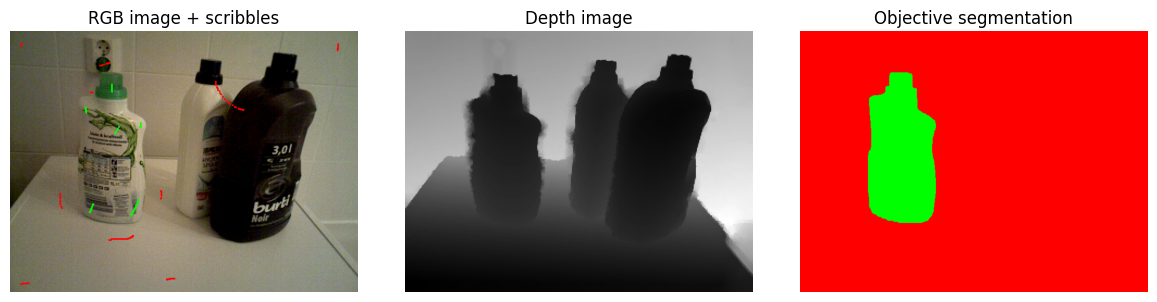

In [3]:
def plot_images_side_by_side(images, titles=None, figsize=None, scale_images=False, max_cols=4):
    n = len(images)
    if titles is None:
        titles = [''] * n
    if figsize is None:
        figsize = (max_cols * 3, ((n // max_cols) + 1) * 3)
    rows = n // max_cols + (1 if n % max_cols else 0)
    cols = min(n, max_cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n == 1:
        axes = [axes]
    for ax, img, title in zip(axes.flat, images, titles):
        if scale_images:
            img = img.resize((200, 200), Image.ANTIALIAS)
        if len(np.array(img).shape) == 2 :
            ax.imshow(img, cmap="gray")
        else :
            ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def superpose_scribbles_on_color(color_image, scribble_image):
    color_array = np.array(color_image)
    scribble_array = np.array(scribble_image)
    scribble_mask = np.any(scribble_array != [255, 255, 255], axis=-1)
    color_array[scribble_mask] = scribble_array[scribble_mask]
    result_image = Image.fromarray(color_array)
    return result_image

depth_image_normalized = 256 * (depth_image - np.min(depth_image)) / (np.max(depth_image) - np.min(depth_image))
color_scribbled_image = superpose_scribbles_on_color(color_image, scribble_image)
plot_images_side_by_side([color_scribbled_image, depth_image_normalized, gt_image], ['RGB image + scribbles','Depth image','Objective segmentation'])

## Computation of the dataterm $f_i$

In [4]:
def extract_scribble_positions_optimized(scribbles, normalize = True):
    """
    Function to extract the positions of users' scribbles pixels and group them by color

    Parameters:
    - scribbles: A numpy array of shape (H, W, 3) representing the scribble image.

    Returns:
    - positions_by_color: A dictionary where each key is a color (tuple of RGB values) and the value is a list of positions (row, col).
    """

    scribbles = np.array(scribbles)
    h, w, _ = scribbles.shape
    unique_colors = np.unique(scribbles.reshape(-1, 3), axis=0)
    non_white_colors = [tuple(color) for color in unique_colors if not np.all(color == [255, 255, 255])]

    positions_by_color = {}

    for color in non_white_colors:
        positions = np.argwhere(np.all(scribbles == color, axis=-1))
        if normalize :
            positions = positions / np.array([h-1, w-1])
        positions_by_color[color] = [tuple(pos) for pos in positions]
    
    return positions_by_color


positions_by_color = extract_scribble_positions_optimized(scribble_image, False)
print(f"there are {len(positions_by_color.keys())} regions to identify in the image")


def rho_i_optimized(color_image, depth_image_normalized, scribble_image, i, alpha):
    """
    Function to compute the rho_i matrix (definited in section 2.2.1 of the report) of the distance kernel's bandwidth.

    Parameters:
    - color_image: A numpy array of shape (H, W, 3) representing the RGB image.
    - depth_image_normalized: A numpy array of shape (H, W, ) representing the depth value.
    - scribble_image: A numpy array of shape (H, W, 3) representing the scribble image.

    Returns: 
    - min_distances_scaled: A numpy array of shape (H, W, ) representing the rho_i matrix.
    - X: A numpy array of shape (H, W, 3) representing the 3D positions of image pixels. 
    - X_ij: A numpy array of shape (m_i, 3) representing the 3D positions of scribbles pixels of region i.
    """

    h, w, _ = color_image.shape
    
    # Extraction and normalization of the scribbles pixels : construction of X_ij
    positions_by_color_i = np.array(list(extract_scribble_positions_optimized(scribble_image, False).values())[i])
    positions_by_color_i_normalized = positions_by_color_i / np.array([h-1, w-1])
    scribble_depths = depth_image_normalized[positions_by_color_i[:, 0], positions_by_color_i[:, 1]]
    scribble_depths_normalized = (scribble_depths - np.min(depth_image_normalized)) / (np.max(depth_image_normalized) - np.min(depth_image_normalized))
    X_ij = np.hstack((positions_by_color_i_normalized, scribble_depths_normalized[:, np.newaxis]))


    # Construction of X (on the whole image)
    rows, cols = np.indices((h, w))
    rows_normalized = rows / (h-1)
    cols_normalized = cols / (w-1)
    depth_normalized = (depth_image_normalized - np.min(depth_image_normalized)) / (np.max(depth_image_normalized) - np.min(depth_image_normalized))
    X = np.dstack((rows_normalized, cols_normalized, depth_normalized)).reshape(-1, 3)


    # Computation of the minimum distances and obtaining the rho_i 
    distances = cdist(X, X_ij, 'euclidean')
    min_distances = np.min(distances, axis=1).reshape(h, w)
    min_distances_scaled = alpha * min_distances


    return min_distances_scaled, X, X_ij


def calculate_distance_matrix(positions, depth_values, h, w):
    """
    Function to compute the distance matrix used for the active scribbles method
    (definited in section 2.3 of the report) between each pixel .

    Parameters:
    - positions: A numpy array of shape (m_i, 3) representing the 3D positions of scribbles pixels of region i.
    - depth_values: A numpy array of shape (H, W, ) representing the depth value of all pixels.

    Returns: 
    - dist_matrix : A numpy array of shape (H, W, m_i) representing the distance matrix of all pixels to scribles of region i.
    """

    # Creating the 2D position 
    Y, X = np.ogrid[:h, :w]

    X = X.astype(np.float32)[:, :, np.newaxis] - positions[:, 1].astype(np.float32)
    Y = Y.astype(np.float32)[:, :, np.newaxis] - positions[:, 0].astype(np.float32)
    Z = depth_values[:, :, np.newaxis] - positions[:, 2].astype(np.float32)

    dist_squared = X**2 + Y**2 + Z**2
    dist_matrix = np.sqrt(dist_squared).astype(np.float32)

    return dist_matrix


def identify_active_scribbles(dist_matrix, threshold = 3.0):
    """
    Function to identify the active method for the active scribbles method (definited in section 2.3 of the report).

    Parameters:
    - dist_matrix: A numpy array of shape (H, W, ) representing the previously computed distance matrix
    - threshold: A float representing the threshold (3 times the minimum distance, cf report).

    Returns: 
    - active_ratio : A numpy array of shape (H, W, ) representing which pixels have a proportion of active pixels >= 80%.
    - active_mask : A numpy array of shape (H, W, m_i) representing which scribbles are active/inactive.
    """    

    # Identification of the active scribbles 
    min_dist = np.min(dist_matrix, axis=2)
    active_mask = dist_matrix <= (threshold * min_dist[:, :, np.newaxis])
    active_mask = active_mask.astype(np.float16)

    # Identification of pixels whose likelihood is going to be computed following the active scribbles method (80%/20%)
    active_counts = np.sum(active_mask, axis=2)
    active_ratio = active_counts / dist_matrix.shape[2]
    return active_ratio >= 0.8, active_mask



def f_i(color_image, depth_image_normalized, scribble_image, i, alpha=1000):
    """
    Function to compute the f_i matrix (definited in section 2.2 of the report) 
    using the 3 kernels and the active method (so the previous functions).

    Parameters:
    - color_image: A numpy array of shape (H, W, 3) representing the RGB image.
    - depth_image_normalized: A numpy array of shape (H, W, ) representing the depth value.
    - scribble_image: A numpy array of shape (H, W, 3) representing the scribble image.
    - i : An integer representing the indice of the region.
    - alpha : A float representing the multiplication parameter used for rho_i computation.

    Returns: 
    - f_i: A numpy array of shape (H, W, ) representing the data term of the segmentation.
    """

    # We prepare the data to be used by the functions
    positions_by_color = extract_scribble_positions_optimized(scribble_image, False)
    positions_by_color_i = np.array(list(positions_by_color.values())[i]) 
    color_image = np.array(color_image).astype(np.int16)  
    h, w, _ = color_image.shape

    # Kernels initialization
    K_combined = np.zeros((h, w))
    K_combined_active = np.zeros((h, w))
    K_combined_passive = np.zeros((h, w))

    # Bandwith definition
    sigma = 0.05
    tau = 0.2
    rho_ii, X, X_ij = rho_i_optimized(color_image, depth_image_normalized, scribble_image, i, alpha)
    X = X.reshape(h, w, 3)
    rho_ii += 1e-9 # To avoid a 0 bandwidth
    depth_image_normalized = (depth_image_normalized - np.min(depth_image_normalized)) / (np.max(depth_image_normalized) - np.min(depth_image_normalized))
    
    # Finding active scribbles
    positions_depth = depth_image_normalized[positions_by_color_i[:, 0], positions_by_color_i[:, 1]]
    positions_by_color_3d = np.hstack((positions_by_color_i, positions_depth[:, np.newaxis]))
    dist_matrix = calculate_distance_matrix(positions_by_color_3d, depth_image_normalized, h, w)
    active_ratio, active_mask = identify_active_scribbles(dist_matrix, 3)
    active_ratio_less_than_80 = active_ratio < 0.8

    for ind, elem in enumerate(positions_by_color_i):

        # elem is a pixel from the region i's scribbles
        elem = tuple(elem)
        
        ### Kernels computation
        # Color kernel
        pixel_color = color_image[elem[0], elem[1], :]
        image_diff = (color_image - pixel_color) / 255.0
        image_diff = np.sqrt(np.sum(image_diff**2, axis=-1))
        K_color = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-image_diff**2 / (2 * sigma**2))

        # Depth kernel
        depth_diff = depth_image_normalized - depth_image_normalized[elem]
        K_depth = (1 / (np.sqrt(2 * np.pi) * tau)) * np.exp(-depth_diff**2 / (2 * tau**2))

        # Distance kernel
        dist_diff = X - X_ij[ind]
        dist_diff = np.sqrt(np.sum(dist_diff**2, axis=-1))
        K_distance = (1 / (np.sqrt(2 * np.pi) * rho_ii)) * np.exp(-dist_diff**2 / (2 * rho_ii**2))


        # Actif and inactive scribbles separate processing
        is_active = active_mask[:, :, ind]
        K_combined_active += is_active * K_color * K_depth * K_distance
        K_combined_passive += (1 - is_active) * K_color * K_depth * K_distance

    # Combinaison of the active/inactive contributions according to the 80% criterion
    K_combined = np.where(active_ratio_less_than_80, 0.8 * K_combined_active + 0.2 * K_combined_passive, K_combined_active + K_combined_passive)
    gc.collect()

    return -np.log(K_combined / len(positions_by_color_i))


there are 2 regions to identify in the image


Let's compute f once and for all :

In [5]:
positions_by_color = extract_scribble_positions_optimized(scribble_image, False)
n = len(positions_by_color.keys())
f_is = [f_i(color_image, depth_image_normalized, scribble_image, i, alpha = 1000) for i in range(n)] 
f = np.stack(f_is, axis=0)

## Optimisation algorithm

### Useful functions

In [6]:
def make_derivative_matrix(w, h):
    """
    Function to create a matrix of the first order differencing.

    Parameters:
    - w, h the dimensions of the wanted matrix

    Returns:
    - D : A sparse matrix representing the first order differencing.
    """
    def generate_D_matrix(m):
        M = np.ones([2,m])
        M[1,:] = -M[1,:] 
        return sparse.spdiags(M, [0,1], m, m)

    Dy = sparse.kron(sparse.eye(w), generate_D_matrix(h)) 
    Dx = sparse.kron(generate_D_matrix(w),sparse.eye(h)) 
    D = sparse.vstack([Dy, Dx])

    return D


def derivative(image):
    """
    Function to create the derivative of an image.

    Parameters: 
    - image: A numpy array of dimensions (n, H, W) with n the number of regions 

    Returns:
    - dxy : A numpy array of dimensions (2, n, H, W) representing the derivative of the image
    """

    n, h, w = image.shape
    dxy = make_derivative_matrix(w, h) @ np.transpose(image, (2, 1, 0)).reshape(-1,n)
    dxy = np.transpose(dxy.reshape(2, w, h, n), (0, 3, 2, 1))

    return dxy


def f_halfg(image, gamma = 5):
    """
    Function to create 1/2*g(x) used to define the simplex (cf section 2.4)

    Parameters: 
    - image: A numpy array of dimensions (n, H, W) with n the number of regions 

    Returns:
    - halfg : A numpy array of dimensions (n, H, W) representing 1/2*g(x)
    """

    grayscale_img = np.mean(image, axis=-1)[None] / 255
    deriv_img = derivative(grayscale_img)

    deriv_img = np.sum(np.abs(deriv_img), axis=0)
    halfg = np.exp(- gamma * deriv_img)/2

    return halfg


def divergence(array):
    """
    Function to create the divergence of an array cf section 2.4

    Parameters: 
    - xi: A numpy array of dimensions (2, n, H, W) with n the number of regions representing the dual variable

    Returns:
    - -dxy : A numpy array of dimensions (2, n, H, W) representing the divergence of xi
    """

    c, h, w = array.shape[1:]
    dxy = make_derivative_matrix(w, h).T @ np.transpose(array, (0, 3, 2, 1)).reshape(-1,c)
    dxy = np.transpose(dxy.reshape(w, h, c), (2, 1, 0))
    return -dxy


def projection_kappa(xi, halfg):
    
    """
    Function to project the dual variable onto the set K (cf section 2.4)

    Parameters: 
    - xi: A numpy array of dimensions (2, n, H, W) representing the dual variable
    - halfg: 1/2 g

    Returns:
    - xi the projected input xi onto K = {|xi|<=g/2}
    """
    # We find where xi exceeds its supposed value
    norm_xi = np.sqrt(xi[0]**2 + xi[1]**2) / halfg 
    exceed  = norm_xi > 1.0

    # Normalization
    xi[0][exceed] = xi[0][exceed] / norm_xi[exceed] 
    xi[1][exceed] = xi[1][exceed] / norm_xi[exceed]

    return xi

def projection_simplex(v):
    """
    Function to project the primal variable onto the simplex B 
    Adapted from : https://gist.github.com/mblondel/6f3b7aaad90606b98f71

    Parameters: 
    - v : A numpy array of dimension (n, H, W) the primal variable

    Returns:
    - w : A numpy array of dimension (n, H, W) which represents the projection of v onto B
    """

    n, H, W = v.shape

    # Sort v into u
    v2d = v.reshape(n, -1)
    u = np.sort(v2d, axis = 0)[::-1]

    # Find rho
    A = np.ones([n,n])
    z = 1
    sum_vecs = (np.tril(A) @ u) - z
    c_vec = np.arange(n)+1.
    c_vec = np.expand_dims(c_vec, axis=0).T
    cond = (u - 1/c_vec * sum_vecs) > 0
    cond_ind = c_vec * cond
    rho = np.max(cond_ind, axis=0)
    rho_n = np.expand_dims(rho.astype(int)-1,0)

    # Compute theta 
    theta = 1 / rho * np.take_along_axis(sum_vecs, indices=rho_n, axis=0)

    # Compute w
    w = v2d-theta
    w[w<0] = 0
    w = w.reshape([n, H, W])
    tmp = np.clip(v, 1e-9, 1)
    tmp = tmp / np.sum(tmp, axis=0, keepdims=True)

    return w


def primal_energy(v, halfg, f, lambd):
    """
    Function used to compute the primal energy 

    Parameters: 
    - v : the current segmentation of dimension (n, W, H)
    - halfg : 1/2 g of dimension (W, H, )
    - f : the dataterm of dimension (n, W, H)

    Returns:
    - energy : A float representing the primal energy of the current segmentation.
    """

    dv = derivative(v)
    energy1 = lambd * np.sum(v * f)
    energy2 = np.sum(halfg * np.sqrt(dv[0]**2 + dv[1]**2))

    return energy1 + energy2

def dual_energy(xi, f, lambd):
    """
    Function used to compute the dual energy.

    Parameters: 
    - xi : the dual variable
    - f : the data term of dimension (n, W, H)

    Returns:
    - energy : A float representing the dual energy of the current segmentation.
    """
    
    return np.sum(np.min(lambd * f - divergence(xi), axis=0))

### Iterations

In [7]:
def dual_update(xi, v_bar, halfg, tau):
    """
    Function used to update the dual variable

    Parameters :
    - xi : A numpy array of shape (2, n, W, H) representing the current dual variable.
    - v_bar : A numpy array of shape (n, W, H) representing the over relaxed variable.
    - tau : A float representing the dual stepsize.
    - halfg : A numpy array of shape (W, H, ) representing the upper bound of kappa

    Returns:
    - A numpy array  of shape (2, n, W, H) representing the new dual variable.
    """

    xi_new = xi + tau * derivative(v_bar)
    
    return projection_kappa(xi_new, halfg)


def primal_update(v, xi, tau, f, lambd):
    """
    Function used to update the primal variable

    Parameters :
    - v : A numpy array of shape (n, W, H) representing the current variable.
    - xi : A numpy array of shape (2, n, W, H) representing the current dual variable.
    - tau : A float representing the primal stepsize.
    - f : A numpy array of shape (n, W, H) representing the data term
    - lambd : A float represnenting the balance parameter (cf 1st equation of the report)

    Returns:
    - A numpy array of shape (n, W, H) representing the new primal variable.
    """

    
    v_new = v + tau * (divergence(xi) - lambd * f)
    
    return projection_simplex(v_new)



def segmentation(image, lambd = 1/10, f = f):
    """
    Summary function used to segment the given image

    Parameters :
    - image : A numpy array of shape (H, W, 3) representing the RGB image.
    - f : A numpy array of shape (n, W, H) representing the data term
    - lambd : A float represnenting the balance parameter (cf 1st equation of the report)

    Returns:
    - v : A numpy array of shape (n, W, H) representing the obtained segmentation
    - A tupple of the energies evolutions over the iterations
    """

    # Initialize
    image = np.array(image)
    h, w, c = image.shape
    xi = np.zeros((2, n, h, w))
    v = np.zeros((n, h, w))
    v_bar = np.zeros((n, h, w))
    halfg = f_halfg(image)
    tau_primal, tau_dual = 0.5, 0.25
    energies = []
    primal_energies, dual_energies = [], []

    # iterate
    for iteration in range(5000):

        if iteration%100 == 0 :
            print(iteration)        

        # Update the variables
        xi_old = xi
        v_old = v
        xi = dual_update(xi_old, v_bar, halfg, tau_dual)
        v = primal_update(v_old, xi, tau_primal, f, lambd)
        v_bar = 2 * v - v_old
        
        # Save energies
        primal_energies.append(primal_energy(v, halfg, f, lambd))
        dual_energies.append(dual_energy(xi, f, lambd))

        # stopping condition : the difference between the energies is < to 0.001%
        if (iteration > 2) and (abs(primal_energies[-1] - dual_energies[-1])/dual_energies[-1] < 1e-5) :
            break

    return v, (energies, primal_energies, dual_energies)

## Results

0
100
200
300
400
500


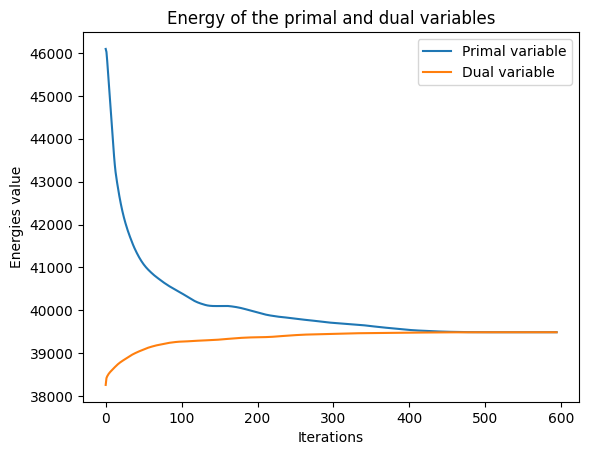

In [8]:
t, tup = segmentation(color_image, lambd=1/55)

x = range(len(tup[1]))
plt.plot(x, tup[1], label='Primal variable')
plt.plot(x, tup[2], label='Dual variable ')
plt.legend()
plt.title('Energy of the primal and dual variables')
plt.xlabel('Iterations')
plt.ylabel('Energies value')
plt.show()

### Visualization 

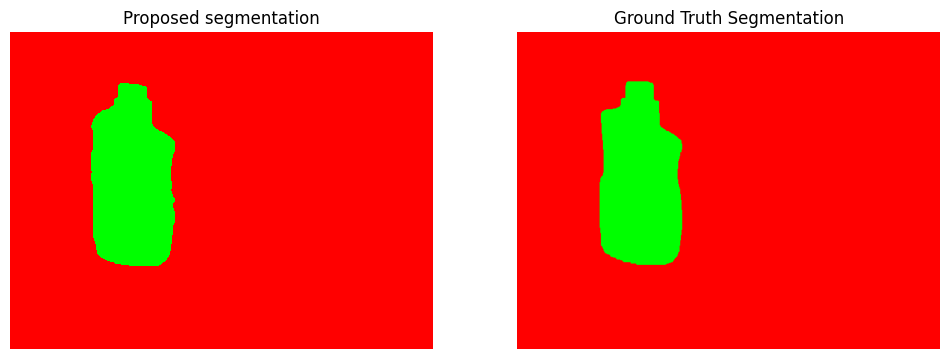

In [9]:
n, h, w = t.shape
indices_max = np.argmax(t, axis=0)
cmap = ListedColormap([[0,1,0], [1,0,0]])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(indices_max, cmap=cmap)
plt.title('Proposed segmentation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gt_image)
plt.title('Ground Truth Segmentation')
plt.axis('off')

plt.show()